# data prepare

In [ ]:
# 数据集路径（这是我电脑上的，使用时也需要修改）
path = r'/hy-tmp/Enderfga/plant_dataset/val' 
# 读取csv中的label
import pandas as pd
df = pd.read_csv(path+'/val'+'_label.csv')
label = df['labels'].unique()
# 给每一种label创建文件夹，若已存在则跳过
import os
for i in df['labels'].unique():
    if not os.path.exists(path+'/'+i):
        os.makedirs(path+'/'+i)
# 将图片移动到对应的文件夹中
import shutil
for i in range(len(df)):
    shutil.copy(path+'/images/'+df['images'][i],path+'/'+df['labels'][i]+'/'+df['images'][i])
# 注意 这里用的是copy不是move，原来的图片还都保存在images文件夹中，训练前需要移走

In [ ]:
# 把scab，scab frog_eye_leaf_spot，scab frog_eye_leaf_spot complex归为scab类
# 把rust，rust complex，rust frog_eye_leaf_spot归为rust类
# 把powdery_mildew，powdery_mildew complex归为powdery_mildew类
# 把frog_eye_leaf_spot，frog_eye_leaf_spot complex归为frog_eye_leaf_spot类
path = r'/hy-tmp/Enderfga/plant_dataset/val' 
import os
import shutil
for i in ['scab frog_eye_leaf_spot','scab frog_eye_leaf_spot complex']:
    if not os.path.exists(path+'/'+i):
        continue
    for j in os.listdir(path+'/'+i):
        shutil.move(path+'/'+i+'/'+j,path+'/scab/'+j)
    os.removedirs(path+'/'+i)
for i in ['rust complex','rust frog_eye_leaf_spot']:
    if not os.path.exists(path+'/'+i):
        continue
    for j in os.listdir(path+'/'+i):
        shutil.move(path+'/'+i+'/'+j,path+'/rust/'+j)
    os.removedirs(path+'/'+i)
for i in ['powdery_mildew complex']:
    if not os.path.exists(path+'/'+i):
        continue
    for j in os.listdir(path+'/'+i):
        shutil.move(path+'/'+i+'/'+j,path+'/powdery_mildew/'+j)
    os.removedirs(path+'/'+i)
for i in ['frog_eye_leaf_spot complex']:
    if not os.path.exists(path+'/'+i):
        continue
    for j in os.listdir(path+'/'+i):
        shutil.move(path+'/'+i+'/'+j,path+'/frog_eye_leaf_spot/'+j)
    os.removedirs(path+'/'+i)

In [ ]:
# mindspore提供的train函数不使用验证集
# 所以需要将验证集中的图片移动到训练集中
import os
import shutil
val_path = r'/hy-tmp/Enderfga/plant_dataset/val'
train_path = r'/hy-tmp/Enderfga/plant_dataset/train'
for i in os.listdir(val_path):
    for j in os.listdir(val_path+'/'+i):
        shutil.move(val_path+'/'+i+'/'+j,train_path+'/'+i+'/'+j)
    os.removedirs(val_path+'/'+i)

# utils

In [4]:
"""Create dataset."""
import os
import mindspore.common.dtype as mstype
import mindspore.dataset.engine as de
import mindspore.dataset.vision as C
import mindspore.dataset.transforms as C2
import mindspore.dataset as das

device_id = 0
device_num = 1


def create_dataset(dataset_path, spilt, repeat_num=1, batch_size=32,num_classes=12):

    """
    Create a train or eval dataset.

    Args:
        dataset_path (str): The path of dataset.
        spilt (str): Whether dataset is used for train or eval.
        repeat_num (int): The repeat times of dataset. Default: 1.
        batch_size (int): The batch size of dataset. Default: 32.

    Returns:
        Dataset.
    """
    if spilt == 'train':
        dataset_path = os.path.join(dataset_path, 'train')
        do_shuffle = True
    elif spilt == 'val':
        dataset_path = os.path.join(dataset_path, 'val')
        do_shuffle = False
    else:
        dataset_path = os.path.join(dataset_path, 'test')
        do_shuffle = False

    if device_num == 1 :
        ds = das.ImageFolderDataset(dataset_path,num_parallel_workers=8, shuffle=do_shuffle,decode=True)
    else:
       ds = das.ImageFolderDataset(dataset_path,num_parallel_workers=8, shuffle=do_shuffle, num_shards=device_num, shard_id=device_id,decode=True)

    resize_height = 224
    resize_width = 224
    buffer_size = 100
    rescale = 1.0 / 255.0
    shift = 0.0

    # define map operations
    #random_crop_op = C.RandomCrop((32, 32), (4, 4, 4, 4))
    random_horizontal_flip_op = C.RandomHorizontalFlip(device_id / (device_id + 1))

    resize_op = C.Resize((resize_height, resize_width))
    rescale_op = C.Rescale(rescale, shift)
    normalize_op = C.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])

    change_swap_op = C.HWC2CHW()

    trans = []
    if spilt == 'train':
        trans += [ random_horizontal_flip_op]
    type_op = C2.TypeCast(mstype.float32)
    trans += [resize_op, rescale_op, normalize_op, change_swap_op,type_op]


    Onehot_op = C2.OneHot(num_classes) #SoftmaxCrossEntropyWithLogits不能用onehot编码
    type_cast_op = C2.TypeCast(mstype.int32)
    
    

    ds = ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=8)
    ds = ds.map(operations=trans, input_columns="image", num_parallel_workers=8)

    # apply batch operations
    ds = ds.batch(batch_size, drop_remainder=True)

    # apply dataset repeat operation
    ds = ds.repeat(repeat_num)
    return ds

batch_size = 32                     # 每批次大小
eval_per_epoch = 2                  # 检查精度的轮次间隔
epoch_size = 50                     # 轮次数量
dataset_path = r'/hy-tmp/Enderfga/plant_dataset'
ds_train = create_dataset(dataset_path, 'train', batch_size=batch_size)
ds_test = create_dataset(dataset_path, 'test', batch_size=batch_size)
Training_size = ds_train.get_dataset_size()*batch_size

In [5]:
"""Pipeline."""
import mindspore as ms
from mindspore import nn
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore.train.callback import Callback
import matplotlib.pyplot as plt


class EvalCallBack(Callback):
    def __init__(self, model, eval_dataset, eval_per_epoch, epoch_per_eval):
        self.model = model
        self.eval_dataset = eval_dataset
        self.eval_per_epoch = eval_per_epoch
        self.epoch_per_eval = epoch_per_eval
 
 
    def on_train_epoch_end(self, run_context):
        cb_param = run_context.original_args()
        cur_epoch = cb_param.cur_epoch_num
        if cur_epoch % self.eval_per_epoch == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.epoch_per_eval["epoch"].append(cur_epoch)
            self.epoch_per_eval["acc"].append(acc["Accuracy"])
            print(acc)
def eval_show(epoch_per_eval,net_name):
    plt.xlabel("epoch number")
    plt.ylabel("Model accuracy")
    plt.title("Model accuracy variation chart")
    plt.plot(epoch_per_eval["epoch"], epoch_per_eval["acc"], "red")
    plt.savefig(net_name+'acc.png')
    plt.show()
def process(network,net_name, ds_train, ds_test, epoch):

    
    status = "train"
    print("=============== 来到训练过程 ==============")
    # 返回当前设备
    device_target = ms.context.get_context('device_target')
    print("当前设备为: {}".format(device_target))
    # 确定图模型是否下沉到芯片上
    dataset_sink_mode = True if device_target in ['Ascend', 'GPU'] else False

    # 设置模型的设备与图的模式
    ms.context.set_context(mode=ms.context.GRAPH_MODE, device_target=device_target)
    # 使用交叉熵函数作为损失函数
    net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
    # 优化器
    net_opt = nn.Momentum(filter(lambda x: x.requires_grad, network.get_parameters()), learning_rate=0.001, momentum=0.9)

    # 建立可训练模型
    model = ms.Model(network=network, loss_fn=net_loss, optimizer=net_opt, metrics={"Accuracy": nn.Accuracy()})

    # 设置CheckpointConfig，callback函数。save_checkpoint_steps=训练总数/batch_size
    ckp_config = CheckpointConfig(save_checkpoint_steps=int(Training_size / batch_size) * eval_per_epoch, keep_checkpoint_max=10)
    ckp_cb = ModelCheckpoint(prefix="checkpoint_{}_verified".format(net_name), directory='results/'+net_name, config=ckp_config)
    # 监控每个epoch训练的时间
    time_cb = TimeMonitor(int(Training_size / batch_size))
    # 监控每次打印时的loss值
    loss_cb = LossMonitor(int(Training_size / batch_size))
    # 监控每个epoch的验证集准确率
    epoch_per_eval = {"epoch": [], "acc": []}  # 方便最后打印精度曲线
    eval_cb = EvalCallBack(model, ds_train, eval_per_epoch, epoch_per_eval)
    

    print("============== 开始训练 ==============")
    model.train(epoch, ds_train, callbacks=[ckp_cb, loss_cb, time_cb,eval_cb], dataset_sink_mode=dataset_sink_mode)
    print("============== 训练结束 ==============")
# -----------------------------------------------------------------------------------------------------------------------
    
    status = "test"
    print("============== 开始测试 ==============")
    res = model.eval(ds_test, dataset_sink_mode=dataset_sink_mode)
    
    # 评估测试集
    print('测试结果:', res)
    eval_show(epoch_per_eval,net_name)
    print("============== 测试结束 ==============")



# LeNet5

=============== 来到训练过程 ==============
当前设备为: GPU
============== 开始训练 ==============
epoch: 1 step: 112, loss is 2.3923087120056152
Train epoch time: 182194.443 ms, per step time: 1626.736 ms
epoch: 2 step: 112, loss is 2.2964911460876465
Train epoch time: 148214.466 ms, per step time: 1323.343 ms
{'Accuracy': 0.25474330357142855}
epoch: 3 step: 112, loss is 2.256774663925171
Train epoch time: 28953.101 ms, per step time: 258.510 ms
epoch: 4 step: 112, loss is 2.2147865295410156
Train epoch time: 145790.588 ms, per step time: 1301.702 ms
{'Accuracy': 0.25474330357142855}
epoch: 5 step: 112, loss is 2.0852854251861572
Train epoch time: 30397.486 ms, per step time: 271.406 ms
epoch: 6 step: 112, loss is 2.0441372394561768
Train epoch time: 152315.356 ms, per step time: 1359.959 ms
{'Accuracy': 0.25558035714285715}
epoch: 7 step: 112, loss is 1.9879432916641235
Train epoch time: 27582.388 ms, per step time: 246.271 ms
epoch: 8 step: 112, loss is 2.0498454570770264
Train epoch time: 145395.

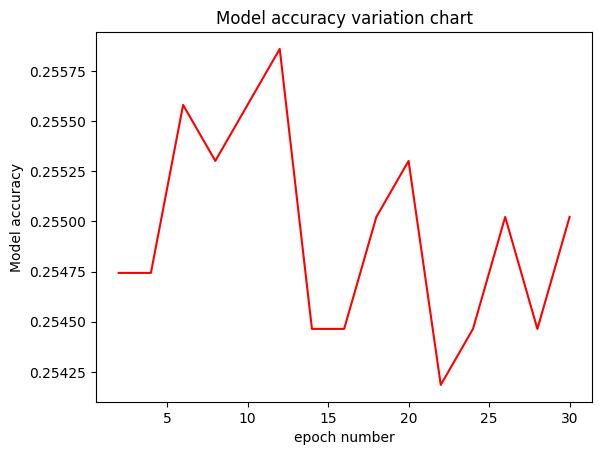

============== 测试结束 ==============


In [6]:
import mindspore.nn as nn
class LeNet5(nn.Cell):
    """
    LeNet-5网络结构
    """
    def __init__(self, num_class=12, num_channel=3):
        super(LeNet5, self).__init__()
        # 卷积层，输入的通道数为num_channel，输出的通道数为6，卷积核大小为5*5
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        # 卷积层，输入的通道数为6，输出的通道数为16，卷积核大小为5*5
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        # 全连接层，输入个数为16*5*5，输出个数为120
        self.fc1 = nn.Dense(16 * 5 * 5, 120)
        # 全连接层，输入个数为120，输出个数为84
        self.fc2 = nn.Dense(120, 84)
        # 全连接层，输入个数为84，分类的个数为num_class
        self.fc3 = nn.Dense(84, num_class)
        # ReLU激活函数
        self.relu = nn.ReLU()
        # 池化层
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # 多维数组展平为一维数组
        self.flatten = nn.Flatten()

    def construct(self, x):
        # 使用定义好的运算构建前向网络
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
# 图片resize为32*32
network = LeNet5(num_class=12)
process(network,'lenet5', ds_train, ds_test, epoch_size)

# Vgg16

=============== 来到训练过程 ==============
当前设备为: GPU
============== 开始训练 ==============
epoch: 1 step: 112, loss is 2.5148966312408447
Train epoch time: 167241.798 ms, per step time: 1493.230 ms
epoch: 2 step: 112, loss is 2.0780904293060303
Train epoch time: 158824.783 ms, per step time: 1418.078 ms
{'Accuracy': 0.29073660714285715}
epoch: 3 step: 112, loss is 2.173339605331421
Train epoch time: 32213.806 ms, per step time: 287.623 ms
epoch: 4 step: 112, loss is 1.9137698411941528
Train epoch time: 155298.556 ms, per step time: 1386.594 ms
{'Accuracy': 0.302734375}
epoch: 5 step: 112, loss is 2.365485191345215
Train epoch time: 31993.538 ms, per step time: 285.657 ms
epoch: 6 step: 112, loss is 2.0239381790161133
Train epoch time: 156794.618 ms, per step time: 1399.952 ms
{'Accuracy': 0.2935267857142857}
epoch: 7 step: 112, loss is 1.9226138591766357
Train epoch time: 30756.538 ms, per step time: 274.612 ms
epoch: 8 step: 112, loss is 2.0665833950042725
Train epoch time: 154979.074 ms, pe

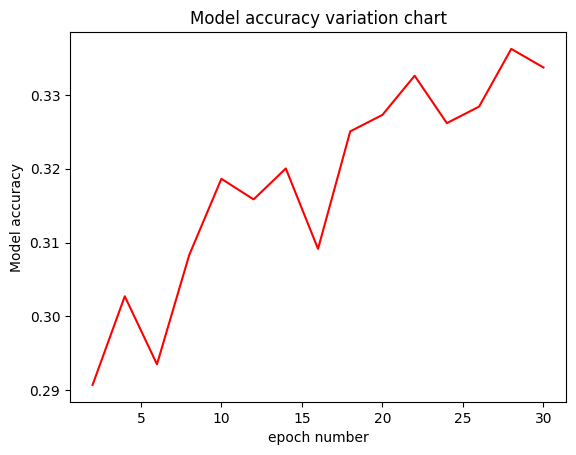

============== 测试结束 ==============


In [3]:
import mindspore.nn as nn
from mindspore.common.initializer import initializer
import mindspore.common.dtype as mstype
import mindspore


def _make_layer(base, batch_norm):
    """Make stage network of VGG."""
    layers = []
    in_channels = 3
    for v in base:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            weight = 'ones'
            # if args.initialize_mode == "XavierUniform":
            # weight_shape = (v, in_channels, 3, 3)
            # weight = initializer('XavierUniform', shape=weight_shape, dtype=mindspore.float32)

            conv2d = nn.Conv2d(in_channels=in_channels,
                               out_channels=v,
                               kernel_size=3,
                               padding=1,
                               pad_mode='pad',
                               has_bias=False,
                               weight_init=weight)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU()]
            else:
                layers += [conv2d, nn.ReLU()]
            in_channels = v
    return nn.SequentialCell(layers)


class Vgg(nn.Cell):
    """
    VGG network definition.
    Args:
        base (list): Configuration for different layers, mainly the channel number of Conv layer.
        num_classes (int): Class numbers. Default: 1000.
        batch_norm (bool): Whether to do the batchnorm. Default: False.
        batch_size (int): Batch size. Default: 1.
        include_top(bool): Whether to include the 3 fully-connected layers at the top of the network. Default: True.
    Returns:
        Tensor, infer output tensor.
    Examples:
        >>> Vgg([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
        >>>     num_classes=1000, batch_norm=False, batch_size=1)
    """

    def __init__(self, base, num_classes=1000, batch_norm=True, phase="train", include_top=True):
        super(Vgg, self).__init__()
        self.layers = _make_layer(base, batch_norm=batch_norm)
        self.include_top = include_top
        self.flatten = nn.Flatten()
        dropout_ratio = 0.5
        has_dropout = True
        if not has_dropout or phase == "test":
            dropout_ratio = 1.0
        self.classifier = nn.SequentialCell([
            nn.Dense(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(dropout_ratio),
            nn.Dense(4096, 4096),
            nn.ReLU(),
            nn.Dropout(dropout_ratio),
            nn.Dense(4096, num_classes)])

    def construct(self, x):
        x = self.layers(x)
        if self.include_top:
            x = self.flatten(x)
            x = self.classifier(x)
        return x


cfg = {
    '11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    '13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    '16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    '19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

net = Vgg(cfg['16'], num_classes=12, batch_norm=True, phase="train", include_top=True)
process(net,'vgg16', ds_train, ds_test, epoch_size)

# ResNet50

=============== 来到训练过程 ==============
当前设备为: GPU
============== 开始训练 ==============
epoch: 1 step: 112, loss is 1.3805581331253052
Train epoch time: 161704.724 ms, per step time: 1443.792 ms
epoch: 2 step: 112, loss is 1.407403826713562
Train epoch time: 146276.430 ms, per step time: 1306.040 ms
{'Accuracy': 0.42940848214285715}
epoch: 3 step: 112, loss is 1.555513620376587
Train epoch time: 30893.225 ms, per step time: 275.832 ms
epoch: 4 step: 112, loss is 1.0754059553146362
Train epoch time: 144288.920 ms, per step time: 1288.294 ms
{'Accuracy': 0.45619419642857145}
epoch: 5 step: 112, loss is 1.419057011604309
Train epoch time: 30626.357 ms, per step time: 273.450 ms
epoch: 6 step: 112, loss is 1.3742318153381348
Train epoch time: 146417.694 ms, per step time: 1307.301 ms
{'Accuracy': 0.43833705357142855}
epoch: 7 step: 112, loss is 1.2259702682495117
Train epoch time: 29825.494 ms, per step time: 266.299 ms
epoch: 8 step: 112, loss is 1.2132371664047241
Train epoch time: 145225.06

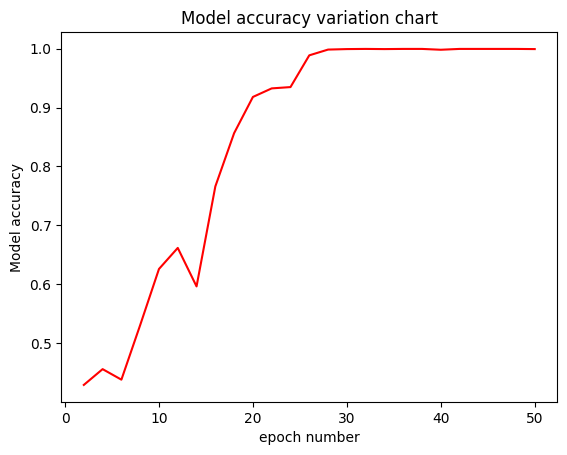

============== 测试结束 ==============


In [3]:
from mindvision.classification.models import resnet50
# 图片resize为224*224
net = resnet50(num_classes=12)
process(net, 'resnet50', ds_train, ds_test, epoch_size)


# Vision Transformer

=============== 来到训练过程 ==============
当前设备为: GPU
============== 开始训练 ==============
epoch: 1 step: 112, loss is 2.364872694015503
Train epoch time: 250624.843 ms, per step time: 2237.722 ms
epoch: 2 step: 112, loss is 1.7558811902999878
Train epoch time: 162311.998 ms, per step time: 1449.214 ms
{'Accuracy': 0.2845982142857143}
epoch: 3 step: 112, loss is 1.8237632513046265
Train epoch time: 34133.316 ms, per step time: 304.762 ms
epoch: 4 step: 112, loss is 1.8459337949752808
Train epoch time: 159435.267 ms, per step time: 1423.529 ms
{'Accuracy': 0.30440848214285715}
epoch: 5 step: 112, loss is 1.4525882005691528
Train epoch time: 33851.389 ms, per step time: 302.245 ms
epoch: 6 step: 112, loss is 1.3554213047027588
Train epoch time: 152305.747 ms, per step time: 1359.873 ms
{'Accuracy': 0.318359375}
epoch: 7 step: 112, loss is 1.804255723953247
Train epoch time: 33893.695 ms, per step time: 302.622 ms
epoch: 8 step: 112, loss is 1.6409599781036377
Train epoch time: 150991.157 ms, pe

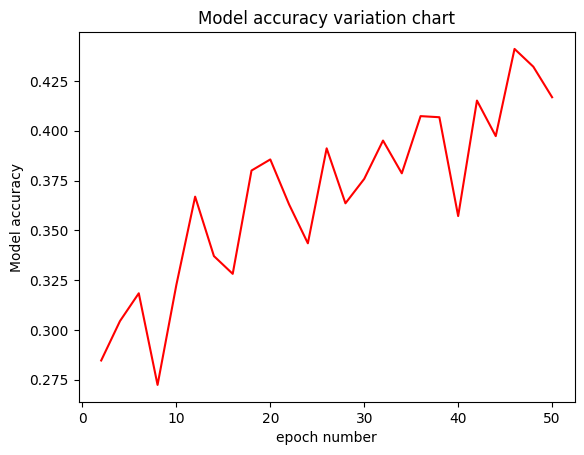

============== 测试结束 ==============


In [6]:
from mindvision.classification.models import vit_l_32
# 图片resize为224*224
net = vit_l_32(num_classes=12)
process(net, 'vit_l_32', ds_train, ds_test, epoch_size)